# Advanced Lane Line detection
---
#### - Ameya Wagh
---

## Importing necessary Modules 

In [28]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import glob
import pickle
%matplotlib inline

### Defining a Camera Model class which models the properties of camera, such as distortion and perspective transformation necessary for correct detection of lines

In [54]:
class CameraModel:
    ''' Model of a pinhole camera used for undistorting images '''
    
    def __init__(self,nx=9,ny=6,calibration_path = 'camera_cal/calibration*.jpg'):
        self.calibration_images = glob.glob(calibration_path)
        self.nx = nx
        self.ny = ny
        self.is_calibrated = False    
    
    def calibrate(self,display=True):
        object_pts = []
        image_pts = []
        
        objpts = np.zeros((self.nx*self.ny,3),np.float32)
        objpts[:,:2] = np.mgrid[0:self.nx, 0:self.ny].T.reshape(-1,2)
        
        for image_file in self.calibration_images:
            img = cv2.imread(image_file)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (self.nx,self.ny), None)
            if ret == True:
                object_pts.append(objpts)
                image_pts.append(corners)
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(
                                                    object_pts,image_pts,
                                                    gray.shape[::-1],None,None)
        is_calibrated = True
        print('[info] camera calibration complete')
        camera_calib = {
            'mtx':self.mtx,
            'dist':self.dist
        }
        pickle.dump(camera_calib,open("camera_calib.pkl","wb"))
        print('[info] camera calibration saved to camera_calib.pkl')
    
    def load_calibration(self):
        camera_calib = pickle.load(open("camera_calib.pkl","rb"))
        self.mtx = camera_calib['mtx']
        self.dist = camera_calib['dist']
        print('[info] camera calibration loaded')
    
    def undistort(self, image):
        return cv2.undistort(image,self.mtx,self.dist,None,self.mtx)
    
    def perspective_transform(self,image):
        undist_img = self.undistort(image)
        if len(image.shape) > 2:
            gray = cv2.cvtColor(undist_img, cv2.COLOR_BGR2GRAY)
        else:
            gray = undist_img
        
        offset = 75 # offset for dst points
        img_size = (undist_img.shape[1], undist_img.shape[0])
        h,w = gray.shape[:2]

        src = np.float32([[w // 2 - offset, h* 0.625], 
                          [w // 2 + offset, h * 0.625], 
                          [offset, h], 
                          [w - offset, h]])

        dst = np.float32([[offset, 0], 
                          [w - offset, 0], 
                          [offset, h], 
                          [w - offset, h]])
        
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_CUBIC)
        
        M_inv = cv2.getPerspectiveTransform(dst, src)
        return warped, M_inv
    
    def inverse_perspective_transform(self, image, M_inv):
        return cv2.warpPerspective(image, M_inv, (image.shape[1],image.shape[0]),flags=cv2.INTER_CUBIC)

## creating instance of CameraModel

In [55]:
camera = CameraModel(calibration_path = 'camera_cal/calibration*.jpg')

## Calibrating camera

In [56]:
# camera.calibrate()
camera.load_calibration()

[info] camera calibration loaded


## Correcting image distortion

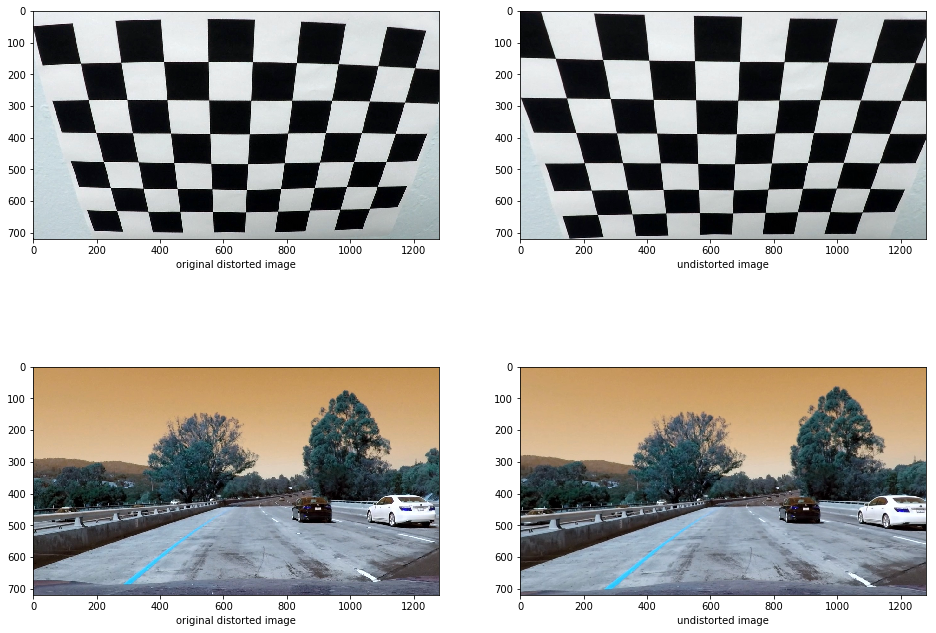

In [57]:
distorted_image_1 = cv2.imread(glob.glob("./camera_cal/calibration2.jpg")[0])
distorted_image_2 = cv2.imread(glob.glob("./test_images/test1.jpg")[0])

undistorted_img_1 = camera.undistort(distorted_image_1)
undistorted_img_2 = camera.undistort(distorted_image_2)

plt.figure(figsize=(16,12))
plt.subplot(221)
plt.imshow(distorted_image_1)
plt.xlabel('original distorted image')

plt.subplot(222)
plt.imshow(undistorted_img_1)
plt.xlabel('undistorted image')

plt.subplot(223)
plt.imshow(distorted_image_2)
plt.xlabel('original distorted image')

plt.subplot(224)
plt.imshow(undistorted_img_2)
plt.xlabel('undistorted image')

plt.show()

## Performing Perspective transformation

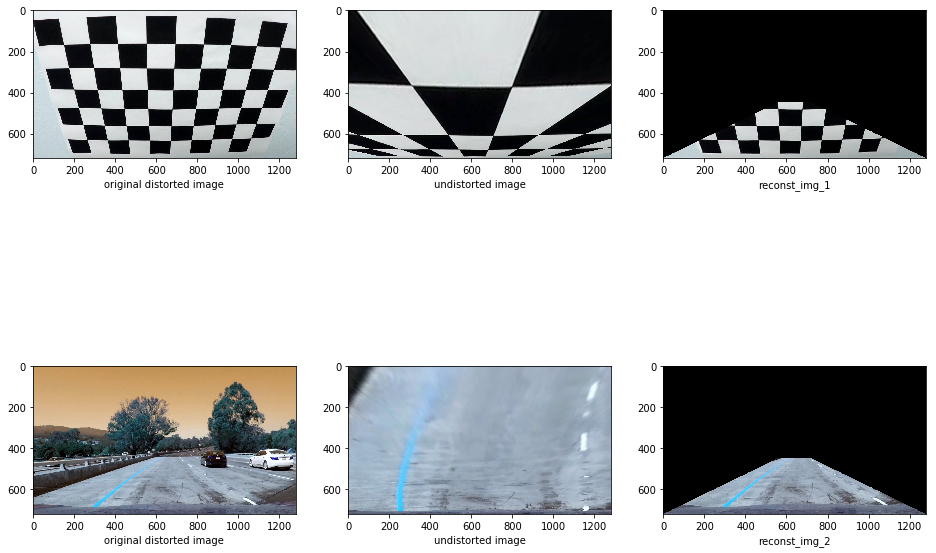

In [58]:
transformed_img_1,M_inv_1 = camera.perspective_transform(distorted_image_1)
transformed_img_2,M_inv_2 = camera.perspective_transform(distorted_image_2)

reconst_img_1 = camera.inverse_perspective_transform(transformed_img_1,M_inv_1)
reconst_img_2 = camera.inverse_perspective_transform(transformed_img_2,M_inv_2)

plt.figure(figsize=(16,12))
plt.subplot(231)
plt.imshow(distorted_image_1)
plt.xlabel('original distorted image')

plt.subplot(232)
plt.imshow(transformed_img_1)
plt.xlabel('undistorted image')

plt.subplot(233)
plt.imshow(reconst_img_1)
plt.xlabel('reconst_img_1')

plt.subplot(234)
plt.imshow(distorted_image_2)
plt.xlabel('original distorted image')

plt.subplot(235)
plt.imshow(transformed_img_2)
plt.xlabel('undistorted image')

plt.subplot(236)
plt.imshow(reconst_img_2)
plt.xlabel('reconst_img_2')

plt.show()

# plt.figure(figsize=(16,12))

# plt.imshow(reconst_img_1)
# plt.show()

In [111]:
class LaneDetector:
    """
    Detects lane lines
    """
    def __init__(self, s_thresh=(170, 255), sx_thresh=(20, 100), 
                 n_windows = 9, margin = 100, minpix = 50,
                 ym_per_pix = 30/720, xm_per_pix = 3.7/700):
        
        self.s_thresh = s_thresh
        self.sx_thresh = sx_thresh
        
        self.lanes_detected = False
        
        self.n_windows = n_windows
        
        self.margin = margin
        self.minpix = minpix
        
        self.ym_per_pix = ym_per_pix
        self.xm_per_pix = xm_per_pix
        
        self.RED   =  [255,0,0]
        self.GREEN =  [0,255,0]
        self.BLUE  =  [0,0,255]
    
    def detect_edges(self,image):
        img = np.copy(image)
        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) 
        abs_sobelx = np.absolute(sobelx) 
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= self.sx_thresh[0]) & (scaled_sobel <= self.sx_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= self.s_thresh[0]) & (s_channel <= self.s_thresh[1])] = 1
        # Stack each channel
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
        
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        
        return combined_binary
    
    def get_lanes(self,binary_warped,visualization = False):
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        midpoint = np.int(histogram.shape[0]//2)
        
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        window_height = np.int(binary_warped.shape[0]//self.n_windows)
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        left_lane_inds = []
        right_lane_inds = []
        
        for window in range(self.n_windows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,
                          (win_xleft_low,win_y_low),
                          (win_xleft_high,win_y_high),
                          (0,255,0), 
                          2) 
            cv2.rectangle(out_img,
                          (win_xright_low,win_y_low),
                          (win_xright_high,win_y_high),
                          (0,255,0), 
                          2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & 
                              (nonzeroy < win_y_high) & 
                              (nonzerox >= win_xleft_low) &  
                              (nonzerox < win_xleft_high)).nonzero()[0]
            
            good_right_inds = ((nonzeroy >= win_y_low) & 
                               (nonzeroy < win_y_high) & 
                               (nonzerox >= win_xright_low) &  
                               (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
        left_fit_cr = np.polyfit(lefty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*self.ym_per_pix, rightx*self.xm_per_pix, 2)
        
        y_eval = np.max(ploty)
        
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*self.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*self.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        true_left_x = left_fit_cr[0]*(y_eval*self.ym_per_pix)**2 + left_fit_cr[1]*(y_eval*self.ym_per_pix) + left_fit_cr[2]
        true_right_x = right_fit_cr[0]*(y_eval*self.ym_per_pix)**2 + right_fit_cr[1]*(y_eval*self.ym_per_pix) + right_fit_cr[2]
        
        car_position = self.xm_per_pix*binary_warped.shape[1]/2
        road_center = (true_left_x + true_right_x)/2

        print(car_position,road_center)
        dist_from_center = road_center - car_position
        
        road_attributes = {'left_radius':left_curverad,
                           'right_radius':right_curverad,
                           'dist_from_center':dist_from_center}
        
        if visualization == True:            
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = self.RED
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = self.BLUE
            print(road_attributes)

            return (left_fit,right_fit),(left_fitx,right_fitx,ploty),out_img
        else:
            return (left_fit,right_fit),out_img
    
    def get_road(self):
        pass

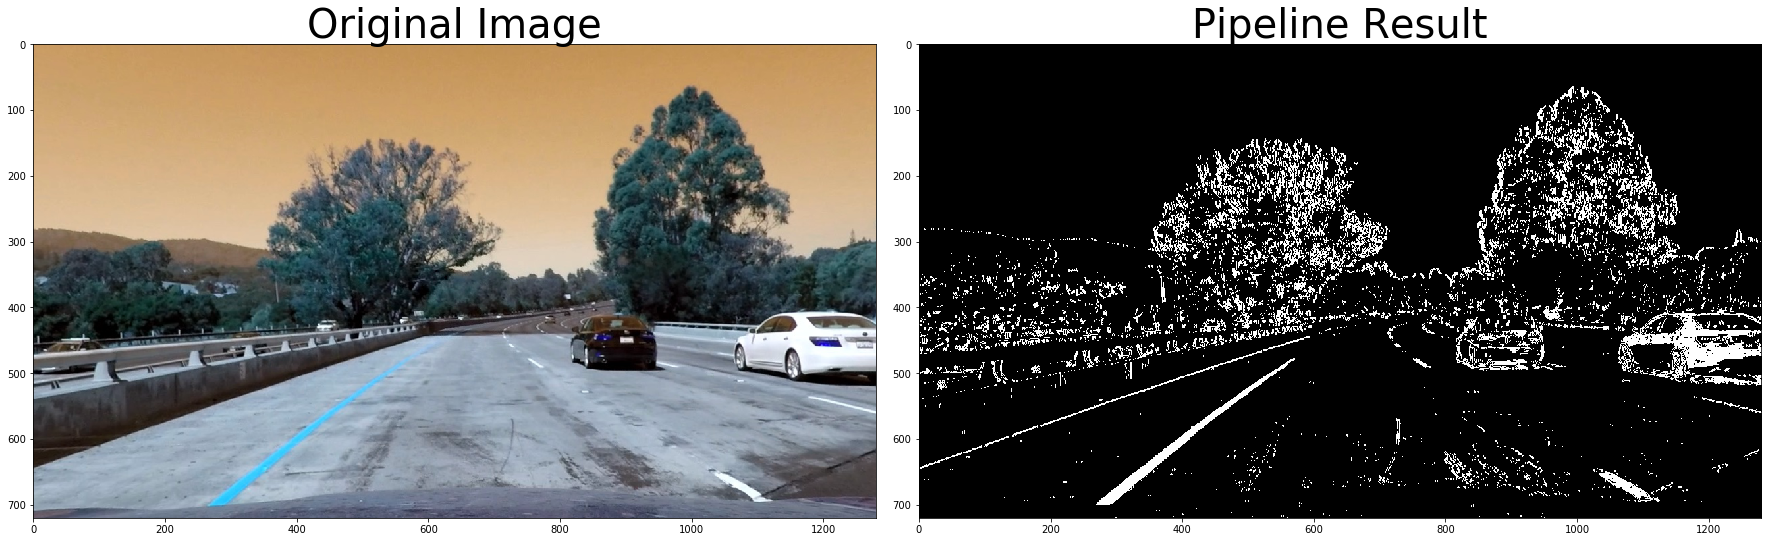

In [112]:
ld = LaneDetector()
result = ld.detect_edges(undistorted_img_2)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted_img_2)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result,cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

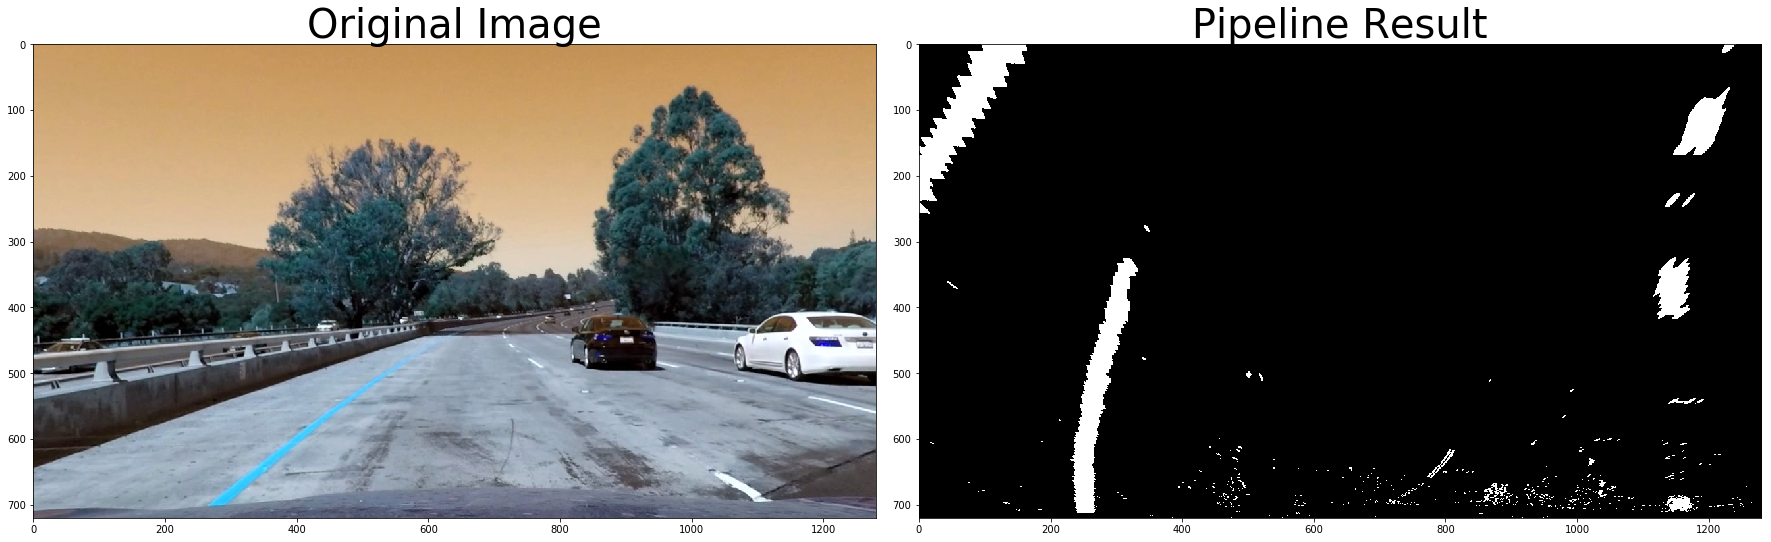

In [113]:
transformed_result,M_inv_result = camera.perspective_transform(result)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted_img_2)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(transformed_result,cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

3.382857142857143 3.71860193069
{'right_radius': 436.55530818271774, 'dist_from_center': 0.3357447878288129, 'left_radius': 338.95242073387908}


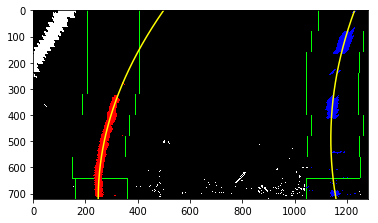

In [114]:
(left_fit,right_fit),(left_fitx,right_fitx,ploty),out_img = ld.get_lanes(transformed_result,visualization=True)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

## Lane detection pipeline
 - undistort image
 - find edges
 - perspective transform to birds-eye view
 - get left and right lane
 - unwarp image

In [ ]:
class LaneLineDetector:
    desc = """
    Lane detection pipeline
    """
    def __init__(self):
        pass
    def __str__(self):
        return desc
    def detect_lane_lines(self):
        pass